In [4]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from textblob import TextBlob
import time
from sklearn.cluster import KMeans
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [5]:
# Load CSV data
data = pd.read_csv("C:/Users/Dell/OneDrive/Desktop/sem 3/NLP/ass-4/Sentiment_Data.csv",encoding='ISO-8859-1',nrows=10000)  # Ensure your CSV has 'Sentiment', 'Count', 'text', and 'label' columns

In [6]:
data.head()

Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

In [7]:
data.shape

(10000, 2)

In [8]:
# Sentiment Mapping
sentiment_mapping = {
    'Strong_Pos': 'Positive',
    'Mild_Pos': 'Positive',
    'Strong_Neg': 'Negative',
    'Mild_Neg': 'Negative',
    'Neutral': 'Neutral'
}

In [9]:
data['Simplified_Sentiment'] = data['Sentiment'].map(sentiment_mapping)

In [10]:
# Fill missing values in 'Tweet' column with an empty string to avoid errors
data['Tweet'] = data['Tweet'].fillna('')

In [11]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
# Extended contraction dictionary
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'t": " not", "'ve": " have", "'m": " am", "i'm": "i am", "you're": "you are",
    "we're": "we are", "they're": "they are", "it's": "it is", "that's": "that is", "there's": "there is"
}

In [14]:
def clean_text(text):
    # 1. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # 2. Remove mentions but keep hashtags
    text = re.sub(r'\@\w+', '', text)
    # 3. Handle contractions
    for contraction, expanded in contractions.items():
        text = re.sub(r"\b{}\b".format(re.escape(contraction)), expanded, text)
    # 4. Remove punctuation and special characters (but keep #)
    text = re.sub(r'[^A-Za-z0-9\s#]', '', text)
    # 5. Tokenize text and remove stop words
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    # 6. Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # 7. Convert to lowercase
    text = ' '.join(words).lower()

    return text

In [15]:
data['cleaned_text'] = data['Tweet'].apply(clean_text)

In [16]:
# Emoji Handling
def handle_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))

In [17]:
data['emoji_handled_text'] = data['cleaned_text'].apply(handle_emoji)

In [18]:
slang_dict = {
    'afaik': 'as far as I know',
    'b4': 'before',
    'b/c': 'because',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'gr8': 'great',
    'gtg': 'got to go',
    'hbu': 'how about you',
    'hmu': 'hit me up',
    'idc': 'I don’t care',
    'idk': "I don't know",
    'ikr': 'I know right',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my f***ing ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the f***',
    'yolo': 'you only live once',
    'y/w': 'you’re welcome',
    'yt': 'YouTube',
    'bff': 'best friend forever',
    'gonna': 'going to',
    'gotta': 'got to',
    'wanna': 'want to',
    'luv': 'love',
    'tho': 'though',
    'abt': 'about',
    '2day': 'today',
    '2moro': 'tomorrow',
    '2nite': 'tonight',
    'pic': 'picture',
    'ppl': 'people',
    'thx': 'thanks',
    'grats': 'congratulations',
    'gr8': 'great',
    'jk': 'just kidding',
    'fam': 'family or close friends',
    'bruh': 'brother or dude',
    'sus': 'suspicious',
    'lit': 'exciting or excellent',
    'savage': 'bold or aggressive',
    'bae': 'before anyone else (significant other)',
    'dope': 'cool or impressive',
    'fomo': 'fear of missing out',
    'fam': 'family or friends',
    'shade': 'disrespect or criticism',
    'stan': 'an extremely devoted fan',
    'snatched': 'looks good or on point',
    'thirsty': 'desperate or attention-seeking'
}

In [19]:
abbreviations_dict = {
    'afaik': 'as far as I know',
    'b/c': 'because',
    'b4': 'before',
    'bff': 'best friend forever',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fb': 'Facebook',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'g2g': 'got to go',
    'gg': 'good game',
    'hmu': 'hit me up',
    'idc': "I don't care",
    'idk': "I don't know",
    'ikr': 'I know right',
    'ily': 'I love you',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmk': 'let me know',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my freaking ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'nbd': 'no big deal',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the freak',
    'yolo': 'you only live once',
    'yw': "you're welcome",
    'yt': 'YouTube',
    'asap': 'as soon as possible',
    'bday': 'birthday',
    'bc': 'because',
    'cuz': 'because',
    'fam': 'family',
    'fb': 'Facebook',
    'gf': 'girlfriend',
    'bf': 'boyfriend',
    'gr8': 'great',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'np': 'no problem',
    'nvm': 'never mind',
    'omw': 'on my way',
    'r': 'are',
    'ttyl': 'talk to you later',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'thx': 'thanks',
    'thnx': 'thanks',
    'bffl': 'best friend for life',
    'ily': 'I love you',
    'atm': 'at the moment',
    'bruh': 'brother',
    'b4n': 'bye for now',
    'bb': 'bye bye',
    'bt': 'but',
    'btwn': 'between',
    'cu': 'see you',
    'ez': 'easy',
    'gratz': 'congratulations',
    'gr8': 'great',
    'hbd': 'happy birthday',
    'imo': 'in my opinion',
    'imma': "I'm going to",
    'j/k': 'just kidding',
    'k': 'okay',
    'lil': 'little',
    'ltns': 'long time no see',
    'm8': 'mate',
    'msg': 'message',
    'mssg': 'message',
    'n1': 'nice one',
    'nc': 'no comment',
    'noob': 'newbie',
    'nm': 'not much',
    'omg': 'oh my god',
    'otw': 'on the way',
    'ppl': 'people',
    'rly': 'really',
    'sup': 'what’s up',
    'tldr': 'too long didn’t read',
    'txt': 'text',
    'wth': 'what the heck',
    'xoxo': 'hugs and kisses',
    'y': 'why',
    'yeet': 'throw with force',
    'zzz': 'sleepy or bored'
}

In [20]:
def handle_slang_and_abbr(text):
    words = text.split()
    words = [slang_dict.get(word.lower(), abbreviations_dict.get(word.lower(), word)) for word in words]
    return ' '.join(words)

In [21]:
data['slang_abbr_handled_text'] = data['emoji_handled_text'].apply(handle_slang_and_abbr)

In [22]:
# A dictionary of antonyms for handling common negations
antonym_dict = {
    'good': 'bad',
    'happy': 'sad',
    'easy': 'difficult',
    'interesting': 'boring',
    'smart': 'dull',
    'like': 'dislike',
    'love': 'hate',
    'success': 'failure',
    'strong': 'weak',
    'possible': 'impossible',
    'safe': 'dangerous'
}

In [23]:
def handle_negation(text):
    # Pattern to match phrases like "not good", "never easy", "no love"
    negation_pattern = r'\b(not|never|no)\s+(\w+)\b'
    
    def replace_with_antonym(match):
        negation, word = match.groups()
        # Replace with antonym if available; otherwise, keep the original phrase
        return antonym_dict.get(word, f"{negation} {word}")
    
    # Substitute negated phrases with their antonyms if available
    text = re.sub(negation_pattern, replace_with_antonym, text)
    
    return text

In [24]:
data['processed_text'] = data['slang_abbr_handled_text'].apply(handle_negation)

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    sentiment_scores = sia.polarity_scores(text)
    polarity = sentiment_scores['compound']  # Overall polarity from -1 to 1
    subjectivity = abs(sentiment_scores['pos'] - sentiment_scores['neg'])  # Approximate subjectivity
    return polarity, subjectivity

In [27]:
# Assuming `data` is your DataFrame with a column 'processed_text'
data[['polarity', 'subjectivity']] = data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [28]:
# Encode target variable (assuming 'Positive', 'Neutral', 'Negative')
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
data['encoded_label'] = data['Simplified_Sentiment'].map(label_mapping)

In [29]:
# Perform train-test split directly on the DataFrame while ensuring >5000 samples in the test set
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

In [ ]:
# Verify test set size
print("Test set size:", len(test_data))
assert len(test_data) > 1000, "Test set must have more than 5000 samples."

In [31]:
# Apply sentiment feature engineering only after splitting
train_data[['polarity', 'subjectivity']] = train_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))
test_data[['polarity', 'subjectivity']] = test_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [32]:
# Extract text and label columns for training and testing
X_train_text = train_data['processed_text'].values
X_test_text = test_data['processed_text'].values
y_train = train_data['encoded_label'].values
y_test = test_data['encoded_label'].values

In [33]:
# Extract the sentiment features for scaling and PCA
train_sentiment = train_data[['polarity', 'subjectivity']]
test_sentiment = test_data[['polarity', 'subjectivity']]

In [34]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer on training data only
sequences = tokenizer.texts_to_sequences(X_train_text)

# Calculate 90th percentile length for padding
lengths = [len(seq) for seq in sequences]
max_length = int(np.percentile(lengths, 90))  # Set max length as the 90th percentile
print("Chosen max_length:", max_length)

Chosen max_length: 24


In [35]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=100, padding='post')

In [36]:
# Scaling and PCA on sentiment features
scaler = StandardScaler()
train_sentiment_scaled = scaler.fit_transform(train_sentiment)  # Fit on training data only
test_sentiment_scaled = scaler.transform(test_sentiment)        # Transform test data with the same scaler

pca = PCA(n_components=2)
train_sentiment_pca = pca.fit_transform(train_sentiment_scaled)  # Fit PCA on training data only
test_sentiment_pca = pca.transform(test_sentiment_scaled)        # Transform test data with the same PCA

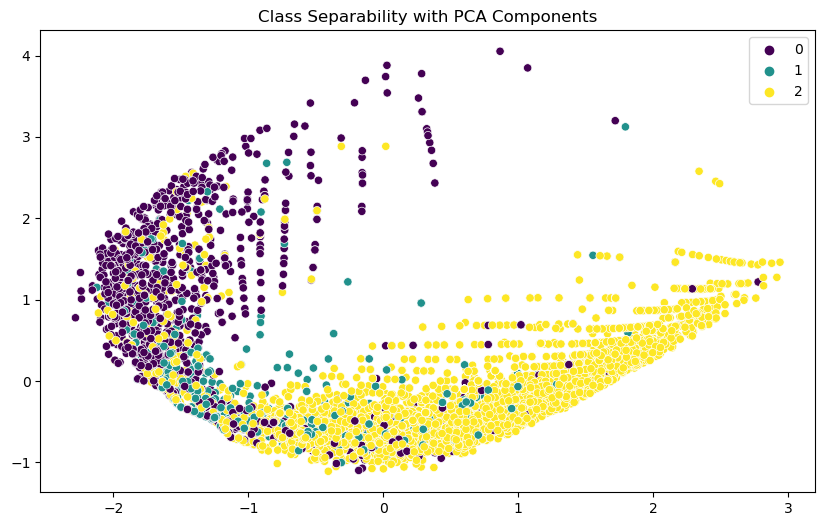

In [37]:
# Create a copy of the sentiment data from the training subset to avoid SettingWithCopyWarning
train_sentiment = train_data[['polarity', 'subjectivity']].copy()
test_sentiment = test_data[['polarity', 'subjectivity']].copy()

# Encode the target variable for class separability check
label_encoder = LabelEncoder()
train_sentiment['target_encoded'] = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_sentiment_pca[:, 0], y=train_sentiment_pca[:, 1], hue=y_train, palette='viridis')
plt.title("Class Separability with PCA Components")
plt.show()

In [38]:
# Calculate silhouette score after performing KMeans clustering
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)

# Explicitly assign cluster labels with .loc to avoid the warning
train_sentiment.loc[:, 'cluster_labels'] = kmeans.fit_predict(train_sentiment[['polarity', 'subjectivity']])

# Calculate the silhouette score
silhouette_avg = silhouette_score(train_sentiment[['polarity', 'subjectivity']], train_sentiment['cluster_labels'])
print(f"Silhouette Score for 'polarity' and 'subjectivity': {silhouette_avg}")


Silhouette Score for 'polarity' and 'subjectivity': 0.5746987266617358


In [39]:
# Bidirectional LSTM Model for 3-class classification
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
vocab_size = 20000

In [40]:
model = Sequential([
    Input(shape=(max_length,)),  # Define input shape in a separate Input layer
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units)),
    Dense(3, activation='softmax')  # 3 output units for Positive, Neutral, and Negative
])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 24, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,019 (10.52 MB)

 Trainable params: 2,758,019 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Model Training and Evaluation
start_time = time.time()
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=128, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 864ms/step - accuracy: 0.6847 - loss: 0.8528 - val_accuracy: 0.7535 - val_loss: 0.6435
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 968ms/step - accuracy: 0.7937 - loss: 0.5420 - val_accuracy: 0.7765 - val_loss: 0.5878
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8859 - loss: 0.3177 - val_accuracy: 0.7755 - val_loss: 0.6255
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 923ms/step - accuracy: 0.9342 - loss: 0.1944 - val_accuracy: 0.7765 - val_loss: 0.7286
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - accuracy: 0.9658 - loss: 0.1149 - val_accuracy: 0.7650 - val_loss: 0.8032


In [44]:
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")
train_time_minutes = train_time / 60
print(f"Training Time: {train_time_minutes:.2f} minutes")

Training Time: 352.75 seconds
Training Time: 5.88 minutes


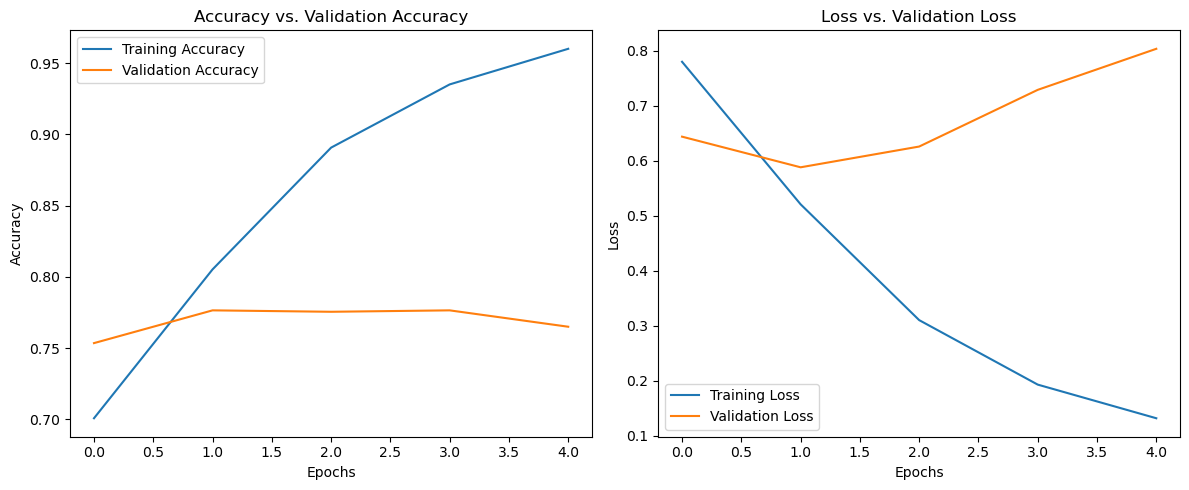

In [45]:
# Plot Accuracy vs. Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Evaluate on Training Data
y_train_pred_prob = model.predict(X_train_padded)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
train_auc = roc_auc_score(pd.get_dummies(y_train), y_train_pred_prob, average='macro', multi_class='ovo')
train_accuracy = accuracy_score(y_train, y_train_pred)

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step


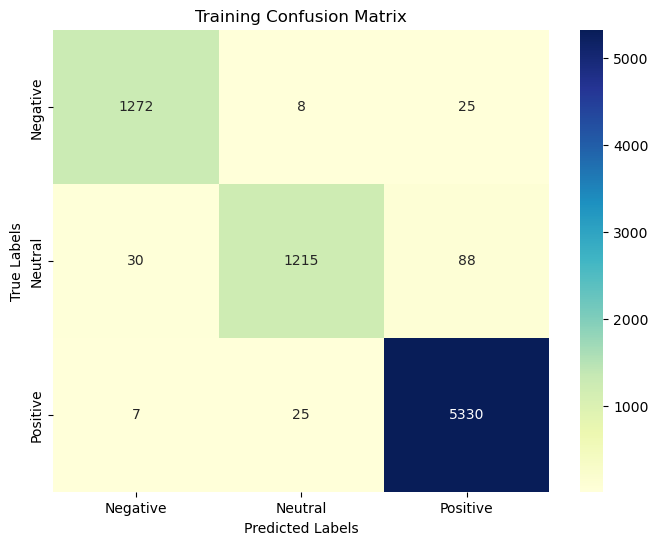

In [47]:
# Calculate the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Training Confusion Matrix")
plt.show()

In [48]:
# Evaluate on Testing Data
y_test_pred_prob = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
test_auc = roc_auc_score(pd.get_dummies(y_test), y_test_pred_prob, average='macro', multi_class='ovo')
test_accuracy = accuracy_score(y_test, y_test_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step


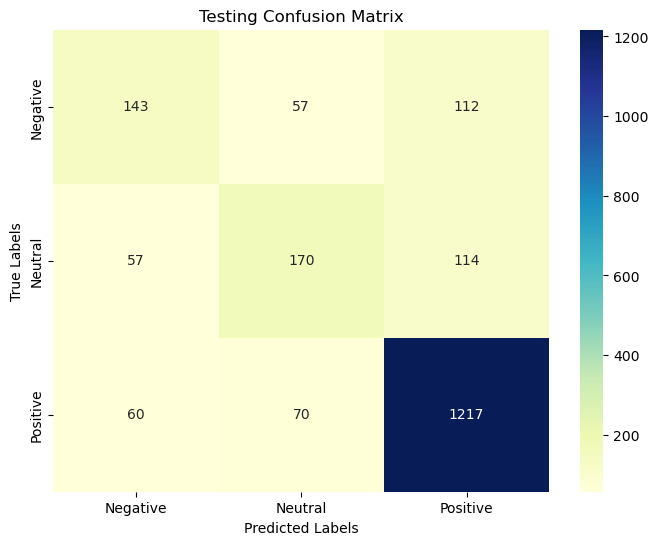

In [50]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Testing Confusion Matrix")
plt.show()

In [51]:
from sklearn.metrics import classification_report

# Training Data Classification Report
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=["Negative", "Neutral", "Positive"]))

Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97      1305
     Neutral       0.97      0.91      0.94      1333
    Positive       0.98      0.99      0.99      5362

    accuracy                           0.98      8000
   macro avg       0.97      0.96      0.97      8000
weighted avg       0.98      0.98      0.98      8000



In [52]:
# Testing Data Classification Report
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Negative", "Neutral", "Positive"]))



Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.46      0.50       312
     Neutral       0.57      0.50      0.53       341
    Positive       0.84      0.90      0.87      1347

    accuracy                           0.77      2000
   macro avg       0.66      0.62      0.64      2000
weighted avg       0.75      0.77      0.76      2000



In [53]:
# Binarize the output for multi-class ROC (one-vs-rest approach)
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])  # Assuming 0: Negative, 1: Neutral, 2: Positive
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

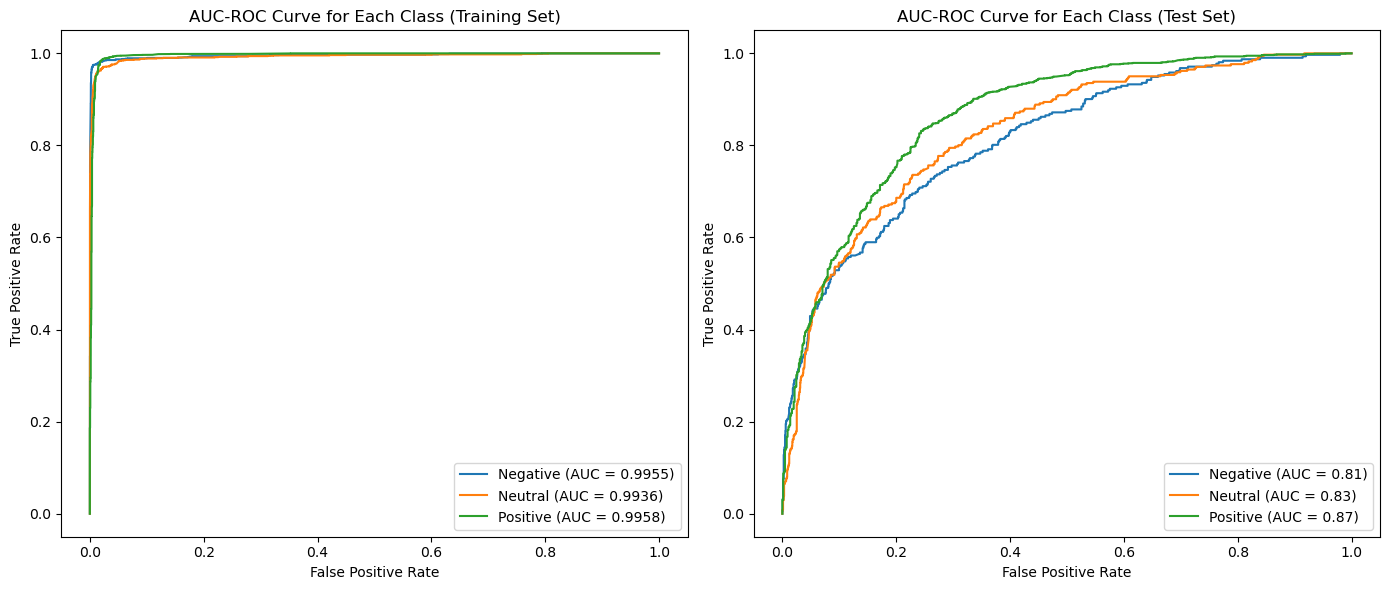

In [54]:
# Plot ROC curve for each class on training data
plt.figure(figsize=(14, 6))

# Training AUC-ROC
plt.subplot(1, 2, 1)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Training Set)")
plt.legend(loc="lower right")

# Testing AUC-ROC
plt.subplot(1, 2, 2)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Test Set)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [55]:
# Ensure you have the original text data from the test set for interpretation
X_test_original_text = test_data['Tweet'].values  # Use the original 'Tweet' column

In [56]:
# Define the prediction function for LIME
def predict_probabilities(texts):
    # Tokenize and pad the texts
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return model.predict(padded_sequences)

In [57]:
# Initialize LIME Text Explainer with class names
explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

In [58]:
# Select a sample index from the test set to explain
sample_index = 0  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [59]:
# Select a sample index from the test set to explain
sample_index = 15  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [60]:
# Select a sample index from the test set to explain
sample_index = 76  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [61]:
import re
from collections import Counter

# Function to extract hashtags from a single tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r"#\w+", tweet)  # Extract words starting with '#'
    return [tag.lower() for tag in hashtags]  # Convert hashtags to lowercase for uniformity

# Apply the function to the dataset
train_data['Hashtags'] = train_data['Tweet'].apply(extract_hashtags)
test_data['Hashtags'] = test_data['Tweet'].apply(extract_hashtags)

# Combine hashtags from all tweets in the dataset
all_hashtags = sum(train_data['Hashtags'], []) + sum(test_data['Hashtags'], [])

print(f"Total Hashtags Extracted: {len(all_hashtags)}")
print(f"Sample Hashtags: {all_hashtags[:10]}")


Total Hashtags Extracted: 8571
Sample Hashtags: ['#1776rm', '#jan6', '#freedomconvoy', '#freedomcorner', '#freedomconvoy', '#freedomconvoy', '#blmriots', '#trudeaumustgo', '#trudeaudestroyingcanada', '#cdnpoli']


In [62]:
# Count frequency of each hashtag
hashtag_counts = Counter(all_hashtags)

# Display the most common hashtags
most_common_hashtags = hashtag_counts.most_common(20)  # Top 20 hashtags
print("Most Common Hashtags:")
for tag, count in most_common_hashtags:
    print(f"{tag}: {count}")


Most Common Hashtags:
#freedomconvoy: 2340
#cdnpoli: 220
#trudeaumustgo: 186
#freedom: 157
#freedumbconvoy: 157
#ottawa: 156
#canada: 150
#honkhonk: 147
#freedomconvoy2022: 144
#freedomconvoy2023: 99
#freedumbers: 98
#convoy: 54
#trudeaudestroyingcanada: 52
#truckersforfreedom: 51
#trudeauisapsychopath: 51
#trudeaumustgonow: 51
#trudeaumustresign: 42
#ottnews: 39
#trudeau: 37
#trudeaudictatorship: 33


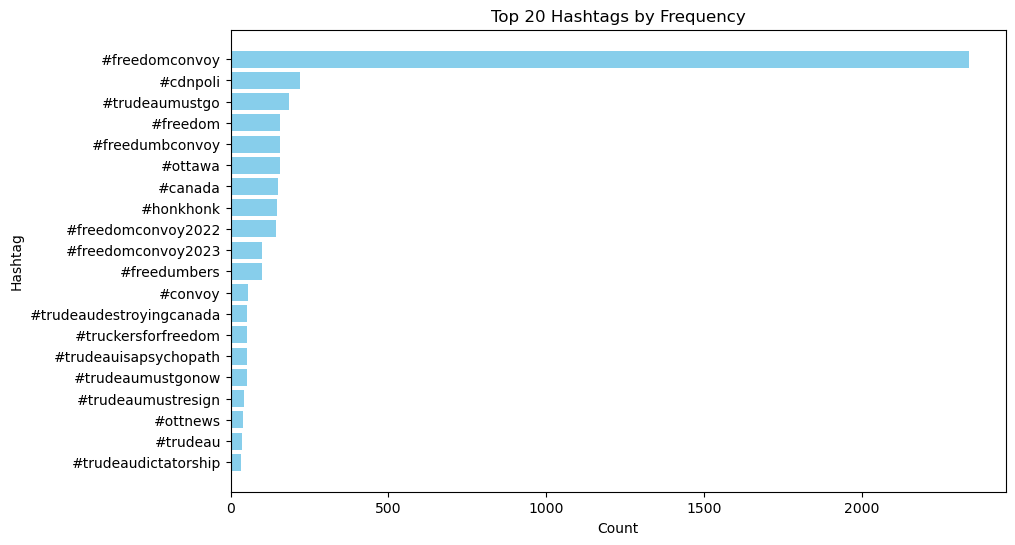

In [63]:
import matplotlib.pyplot as plt

# Convert to a DataFrame for visualization
hashtag_df = pd.DataFrame(most_common_hashtags, columns=['Hashtag', 'Count'])

# Plot the top hashtags
plt.figure(figsize=(10, 6))
plt.barh(hashtag_df['Hashtag'], hashtag_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.title('Top 20 Hashtags by Frequency')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


In [70]:
def filter_tweets_by_hashtag(data, hashtag):
    hashtag = hashtag.lower().strip("#")
    filtered_data = data[data['Tweet'].str.contains(f"#{hashtag}", case=False, na=False)]
    return filtered_data

# Example usage
hashtag = "#convoy"  # Change to your desired hashtag
filtered_tweets = filter_tweets_by_hashtag(test_data, hashtag)

if len(filtered_tweets) == 0:
    print(f"No tweets found for hashtag: {hashtag}")
else:
    print(f"Filtered Tweets for {hashtag}: {len(filtered_tweets)} tweets")


Filtered Tweets for #convoy: 23 tweets


In [71]:
def analyze_sentiment_and_classify_risk(filtered_tweets, tokenizer, max_length, model):
    if filtered_tweets.empty:
        return "No tweets found for this hashtag."

    # Preprocess tweets for prediction
    sequences = tokenizer.texts_to_sequences(filtered_tweets['processed_text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Predict sentiments
    predictions = model.predict(padded_sequences)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class with highest probability

    # Map predictions back to sentiment labels and classify risk
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    risk_mapping = {"Negative": "High Risk", "Neutral": "Medium Risk", "Positive": "Low Risk"}
    predicted_sentiments = pd.Series(predicted_classes).map(sentiment_mapping)
    risk_classification = predicted_sentiments.map(risk_mapping).value_counts(normalize=True) * 100

    return risk_classification

# Example usage
risk_summary = analyze_sentiment_and_classify_risk(filtered_tweets, tokenizer, max_length, model)
print("Risk Classification Summary for Hashtag:")
print(risk_summary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Risk Classification Summary for Hashtag:
Low Risk       78.260870
Medium Risk    17.391304
High Risk       4.347826
Name: proportion, dtype: float64


In [76]:
import pickle

# Save the trained LSTM model
model.save('C:/Users/Dell/OneDrive/Desktop/sem 3/deploymnet/Final Presentation/lstm_model.h5')

# Save the tokenizer
with open('C:/Users/Dell/OneDrive/Desktop/sem 3/deploymnet/Final Presentation/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
